In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from skimage.feature import local_binary_pattern

In [7]:
def load_images_from_folder(folder, size=(50, 50)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, size)
            images.append(img_resized)
    return images

def extract_features(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    hist = cv2.normalize(hist, hist).flatten()
    edges = cv2.Canny(image, 100, 200).flatten()
    feature_vector = np.concatenate((hist, edges))
    return feature_vector

def prepare_data(positive_folder, negative_folder, num_images=100):
    positive_images = load_images_from_folder(positive_folder)[:num_images]
    positive_labels = [1] * len(positive_images)
    negative_images = load_images_from_folder(negative_folder)[:num_images]
    negative_labels = [0] * len(negative_images)
    all_images = positive_images + negative_images
    all_labels = positive_labels + negative_labels
    features = []
    print("Extracting features...")
    for img in tqdm(all_images, desc="Feature Extraction Progress"):
        feature_vector = extract_features(img)
        features.append(feature_vector)
    return np.array(features), np.array(all_labels)


In [8]:

model_path = "svm_weightsd1.joblib"
scaler_path = "scaler_weightsd1.joblib"

positive_folder = 'Dataset1/defect'
negative_folder = 'Dataset1/nodefect'
X, y = prepare_data(positive_folder, negative_folder)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if os.path.exists(model_path) and os.path.exists(scaler_path):
    svm = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    print("Loaded saved model and scaler.")
else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training the SVM
    svm = SVC(kernel='linear')
    svm.fit(X_train_scaled, y_train)

    joblib.dump(svm, model_path)
    joblib.dump(scaler, scaler_path)
    print("Model and scaler trained and saved.")

if not os.path.exists(model_path):
    X_test_scaled = scaler.transform(X_test)

y_pred = svm.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))


Extracting features...


Feature Extraction Progress: 100%|██████████| 200/200 [00:00<00:00, 8279.89it/s]

Model and scaler trained and saved.
Accuracy: 0.9333333333333333


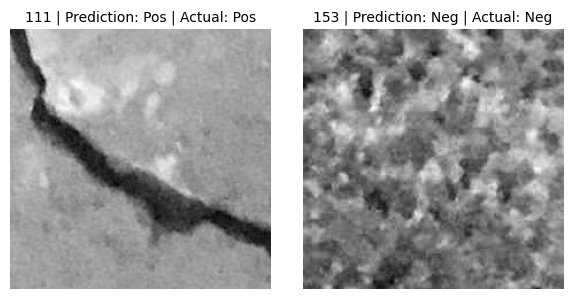

In [9]:

def plot_images_side_by_side(rand1, rand2, svm_model, scaler):
    pos_img_path = 'Dataset1/defect/00' + str(rand1) + '.jpg'
    neg_img_path = 'Dataset1/nodefect/00' + str(rand2) + '.jpg'
    
    pos_img = cv2.imread(pos_img_path, cv2.IMREAD_GRAYSCALE)
    neg_img = cv2.imread(neg_img_path, cv2.IMREAD_GRAYSCALE)
    
    pos_resized = cv2.resize(pos_img, (50, 50))
    neg_resized = cv2.resize(neg_img, (50, 50))
    
    pos_feature_vector = extract_features(pos_resized)
    neg_feature_vector = extract_features(neg_resized)
    
    pos_scaled = scaler.transform([pos_feature_vector])
    neg_scaled = scaler.transform([neg_feature_vector])
    
    pos_pred = svm_model.predict(pos_scaled)[0]
    neg_pred = svm_model.predict(neg_scaled)[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    axes[0].imshow(pos_img, cmap='gray')
    axes[0].set_title(f"{rand1} | Prediction: {'Neg' if pos_pred==0 else 'Pos'} | Actual: Pos", fontsize=10)
    axes[0].axis('off')

    axes[1].imshow(neg_img, cmap='gray')
    axes[1].set_title(f"{rand2} | Prediction: {'Neg' if neg_pred==0 else 'Pos'} | Actual: Neg", fontsize=10)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

rand1 = np.random.randint(100, 201)
rand2 = np.random.randint(100, 201)
plot_images_side_by_side(rand1, rand2, svm, scaler)



Results for Positive Image 1


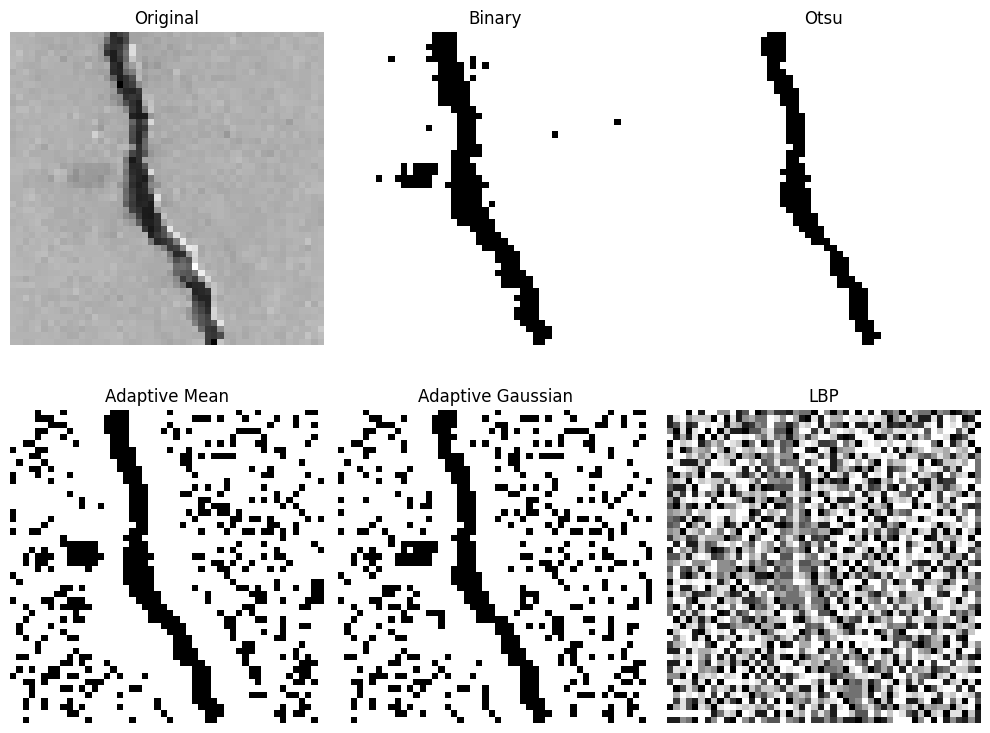


Results for Positive Image 2


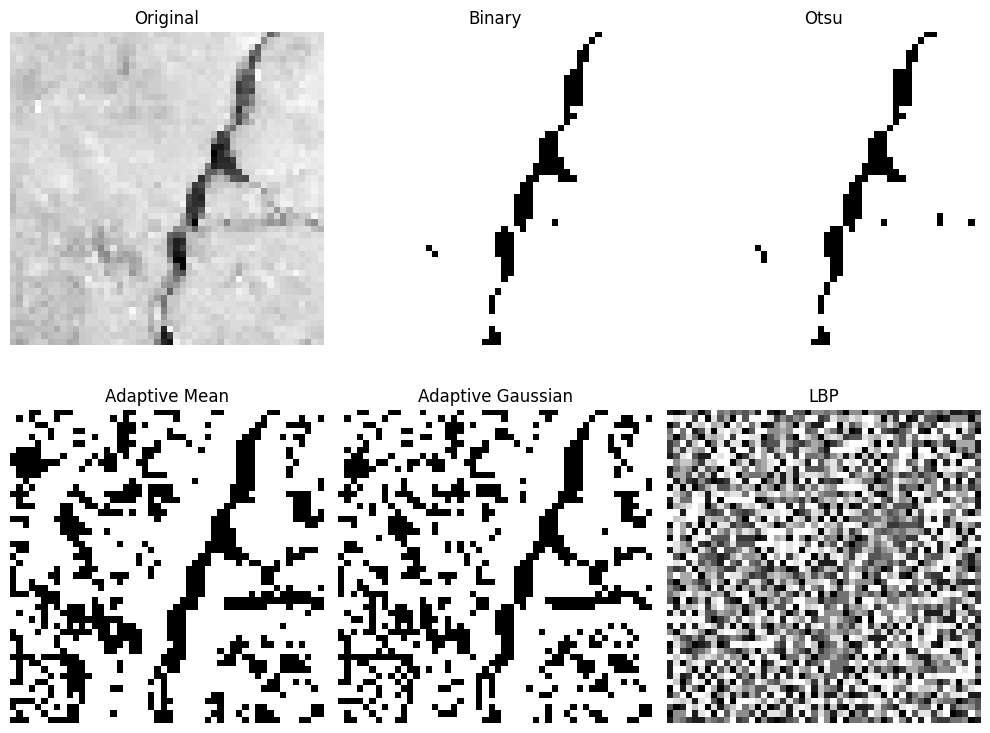

In [10]:


positive_folder = 'Dataset1/defect'
num_images = 2

def load_images_from_folder(folder, size=(50, 50)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(cv2.resize(img, size))
    return images[:num_images]

positive_images = load_images_from_folder(positive_folder)

def classify_and_filter_positive_images(images, svm_model, scaler):
    positive_filtered_images = []
    for img in images:
        feature_vector = extract_features(img)
        scaled_features = scaler.transform([feature_vector])
        if svm_model.predict(scaled_features)[0] == 1:
            positive_filtered_images.append(img)
    return positive_filtered_images

def apply_thresholds(image):
    return {
        "Binary": cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)[1],
        "Otsu": cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1],
        "Adaptive Mean": cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2),
        "Adaptive Gaussian": cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    }

def calculate_lbp(image, radius=1, points=8):
    return local_binary_pattern(image, points, radius, method="uniform")

def plot_results(image, thresholds, lbp_image):
    plt.figure(figsize=(10, 8))
    images = [image] + list(thresholds.values()) + [lbp_image]
    titles = ["Original", "Binary", "Otsu", "Adaptive Mean", "Adaptive Gaussian", "LBP"]
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, 3, i)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def segment_and_analyze(positive_images):
    for i, image in enumerate(positive_images):
        thresholds = apply_thresholds(image)
        lbp_image = calculate_lbp(image)
        print(f"\nResults for Positive Image {i + 1}")
        plot_results(image, thresholds, lbp_image)

segment_and_analyze(positive_images)
